## CVBankas IT srities skelbimų analizė

Darbo metu buvo parašytas "gremžtukas"/"voriukas", kuris patikrina cvbankas.lt darbo skelbimų sveatinės turinį, parsiunčia esminę skelbimų informaciją ir ją išsaugo *.csv faile.

Visa analizė veiks tiesiog atsidarius failą `cvbankas.ipynb` per Jupyter Notebook, norint gauti aktualių skelbimų sąrašą reikia paleisti `main.py` failą konsolėje įvykdant komandą `python main.py`.
Komandos vykdymas užims šiek tiek laiko, nes IT srities darbo skelbimų skaičius yr virš 600, jie puslapiuoti po 50 skelbimų į puslapį.

"Voriuko" kodas yra [main.py](./main.py) faile.
Duomenų surinkimui iš `html` kodo panaudota `lxml` biblioteka, skelbimo įrašo išdaugojimui sukurta klasė `StoreItem`.

Funkcija `get_pages()` skirta nuskaityti pagrindinį skelbimų puslapį ir nustatyti, kiek puslapiavimo elementų yra skelbimų sąraše (9-13 eilutės).

Turėdami puslapių skaičių iteruojame per juos visus (23-47 eilutės) ir vykdome funkciją `get_source()`.

Iteracijos metu nuskaitome kiekvieną skelbimą, iš `html` kodo pasiimame šią informaciją:

  - skelbimo pavadinimas;
  - įmonės pavadinimas;
  - skelbimo nuoroda;
  - miestas;
  - prieš kiek dienų/valandų įkeltas skelbimas;
  - siūlomo atlygio informaciją (informacija apie atlyginimą pateikiama labai skirtingai: rėžiai min-max; nuo xxx EUR; iki XXX EUR; XX EUR/val., arba visai nepateikiama. Negana to, visa informacija gali būti pateikti ir skirtingai mokestinei bazei - brutto, arba netto. Šiam laukeliui sutvarkyti bus naudojamos atskiros manipuliacijos duomenų tvarkymo metu.)

Kai jau turime visą dominančią informaciją, suformuojame skelbimo objektą, pridedame jį į sarašą. 

Pabaigę iteracijas per visus puslapius iš gauto sąrašo siformuojama duomenų masyvą (dataframe) ir jį išsaugome į *.csv failą.

"Voriuko" darbas baigtas.

In [112]:
'''
Susiimportuojame visas reikiamas bibliotekas, reikalingas
duomenų manipuliacijai ir grafikų piešimui.
Gera idėja turėti importus atskiroje celėje, nes pridėjus
papildomą importą galima perleisti celę iš naujo ir nereikės
kartoti kiekvienos paskesnės celės (ką reikėtų daryti, jeigu,
pvz. vienoje celėje su importais būtų ir duoemnų nuskaitymas).
'''
import pandas as pd
import numpy as np
import re
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

In [113]:
# Nuskaitome duomenis, tuščius laukelius užpildome "0"
df = pd.read_csv('adds.csv')
df.fillna('0', inplace=True)
df.head()

,company,old,title,link,salary,netgross,city
0,UAB „Nordcode technology“,prieš 1 d.,BUSINESS ANALYST (WEB SYSTEMS),https://www.cvbankas.lt/business-analyst-web-s...,3000-4500,Neatskaičius mokesčių,Vilniuje
1,UAB „WAAVO“,prieš 5 d.,Senior PHP programuotojas,https://www.cvbankas.lt/senior-php-programuoto...,2000-5000,Į rankas,Vilniuje
2,FREDA LEZ,prieš 6 d.,IT projektų vadovas (-ė) (LEZ),https://www.cvbankas.lt/it-projektu-vadovas-e-...,2500-3500,Neatskaičius mokesčių,Kaune
3,UAB „Furniture1“,prieš 8 d.,Junior - Mid FULL STACK developer,https://www.cvbankas.lt/junior-mid-full-stack-...,1300-2000,Į rankas,Vilniuje
4,UAB „Softemia LT“,prieš 14 d.,MAINTENANCE ENGINEER,https://www.cvbankas.lt/maintenance-engineer-v...,1500-2200,Į rankas,Vilniuje


In [114]:
'''
Funkcijos min ir max atlyginimo ištraukimui - ištraukiamos
tik skaitinės reikšmės iš atlyginimo laukelio
'''
# minsalary
pattern = re.compile(r'\d+')
def lower_val(s):
    lower = pattern.search(s)
    return int(lower.group())

# maxsalary
pattern2 = re.compile(r'\d+$')
def upper_val(s):
    upper = pattern2.search(s)
    return int(upper.group())

In [115]:
# Ištraukiame min ir max atlyginimo reikšmes iš 'salary' laukelio
# "skaitmenizuojame" brutto/netto
df['minsalary'] = df['salary'].apply(lower_val)
df['maxsalary'] = df['salary'].apply(upper_val)
df['ngcat'] = df['netgross'].replace('Į rankas',int(2))
df.ngcat[df.netgross == 'Neatskaičius mokesčių'] = int(1)

/tmp/ipykernel_7129/3360965149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ngcat[df.netgross == 'Neatskaičius mokesčių'] = int(1)


In [116]:
# Privedame visą atlygį prie NETTO
df.loc[df.ngcat==1, "mins"] = df.minsalary*0.6
df.loc[df.ngcat==1, "maxs"] = df.maxsalary*0.6
df.loc[df.ngcat==2, "mins"] = df.minsalary
df.loc[df.ngcat==2, "maxs"] = df.maxsalary
df.loc[df.ngcat==0, "mins"] = df.minsalary
df.loc[df.ngcat==0, "maxs"] = df.maxsalary
df.head()

,company,old,title,link,salary,netgross,city,minsalary,maxsalary,ngcat,mins,maxs
0,UAB „Nordcode technology“,prieš 1 d.,BUSINESS ANALYST (WEB SYSTEMS),https://www.cvbankas.lt/business-analyst-web-s...,3000-4500,Neatskaičius mokesčių,Vilniuje,3000,4500,1,1800.0,2700.0
1,UAB „WAAVO“,prieš 5 d.,Senior PHP programuotojas,https://www.cvbankas.lt/senior-php-programuoto...,2000-5000,Į rankas,Vilniuje,2000,5000,2,2000.0,5000.0
2,FREDA LEZ,prieš 6 d.,IT projektų vadovas (-ė) (LEZ),https://www.cvbankas.lt/it-projektu-vadovas-e-...,2500-3500,Neatskaičius mokesčių,Kaune,2500,3500,1,1500.0,2100.0
3,UAB „Furniture1“,prieš 8 d.,Junior - Mid FULL STACK developer,https://www.cvbankas.lt/junior-mid-full-stack-...,1300-2000,Į rankas,Vilniuje,1300,2000,2,1300.0,2000.0
4,UAB „Softemia LT“,prieš 14 d.,MAINTENANCE ENGINEER,https://www.cvbankas.lt/maintenance-engineer-v...,1500-2200,Į rankas,Vilniuje,1500,2200,2,1500.0,2200.0


In [117]:
#  Max atlyginimų reikšmių distribucija
df.groupby('maxs').count().head(15)

,company,old,title,link,salary,netgross,city,minsalary,maxsalary,ngcat,mins
maxs,,,,,,,,,,,
9.0,2,2,2,2,2,2,2,2,2,2,2
12.0,1,1,1,1,1,1,1,1,1,1,1
15.0,1,1,1,1,1,1,1,1,1,1,1
24.0,1,1,1,1,1,1,1,1,1,1,1
438.0,1,1,1,1,1,1,1,1,1,1,1
441.0,1,1,1,1,1,1,1,1,1,1,1
480.0,1,1,1,1,1,1,1,1,1,1,1
498.0,2,2,2,2,2,2,2,2,2,2,2
540.0,1,1,1,1,1,1,1,1,1,1,1


In [118]:
# Min atlyginimų reikšmių distribucija
df.groupby('mins').count().head(15)

,company,old,title,link,salary,netgross,city,minsalary,maxsalary,ngcat,maxs
mins,,,,,,,,,,,
5.4,1,1,1,1,1,1,1,1,1,1,1
6.0,1,1,1,1,1,1,1,1,1,1,1
438.0,1,1,1,1,1,1,1,1,1,1,1
441.0,1,1,1,1,1,1,1,1,1,1,1
445.8,1,1,1,1,1,1,1,1,1,1,1
450.0,2,2,2,2,2,2,2,2,2,2,2
480.0,3,3,3,3,3,3,3,3,3,3,3
498.0,2,2,2,2,2,2,2,2,2,2,2
500.0,1,1,1,1,1,1,1,1,1,1,1


In [119]:
# Išvalome duomenis su valandiniu atlygiu (mins arba maxs < 438)
df = df[df.maxs > 437]

In [120]:
# bins reikšmė grafikams
bins=50

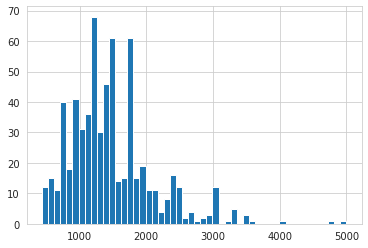

In [121]:
minhist = df.mins.hist(bins=bins)

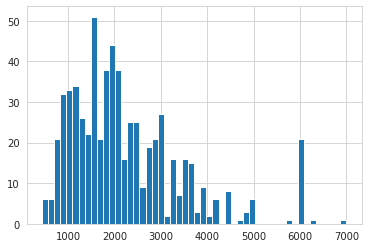

In [122]:
maxhist = df.maxs.hist(bins=bins)

In [123]:
# Statistika "į rankas"
print(df[['mins','maxs']].describe())

             mins         maxs
count   632.00000   632.000000
mean   1474.11962  2233.832911
std     639.22933  1219.776267
min     438.00000   438.000000
25%    1020.00000  1364.750000
50%    1380.00000  1983.600000
75%    1800.00000  2820.000000
max    5000.00000  7000.000000


<AxesSubplot:xlabel='mins', ylabel='city'>

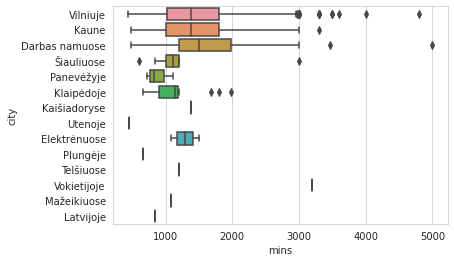

In [124]:
sns.boxplot(y='city', x='mins', data=df, orient='h')

<AxesSubplot:xlabel='maxs', ylabel='city'>

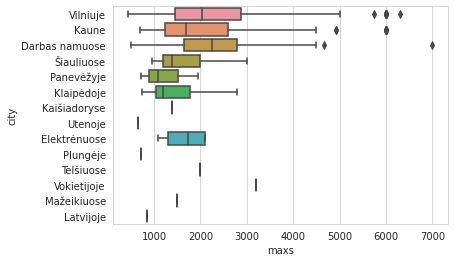

In [125]:
sns.boxplot(y='city', x='maxs', data=df, orient='h')

In [126]:
rinka = df['city'].value_counts(ascending=False)
rinka

Vilniuje          426
Kaune             111
Darbas namuose     54
Klaipėdoje         18
Šiauliuose          9
Elektrėnuose        4
Panevėžyje          3
Kaišiadoryse        1
Utenoje             1
Plungėje            1
Telšiuose           1
Vokietijoje         1
Mažeikiuose         1
Latvijoje           1
Name: city, dtype: int64

Iš aukščiau esančio sąrašo matome, kad didžiausia pasiūla yra Vilniuje, Kaune ir "darbas iš namų". Kituose miestuose pasiūla praktiškai neegzistuoja. Į šį faktorių derėtų atsižvelgti ir analizuojant Iš aukščiau esančio sąrašo matome, kad didžiausia pasiūla yra Vilniuje, Kaune ir "darbas iš namų". Kituose miestuose pasiūla praktiškai neegzistuoja. Į šį faktorių derėtų atsižvelgti ir analizuojant `boxplot` grafikus, juose matomą duomenų išsibarstymą.
Dar kartą pakartosiu `describe()` statistiką žemiau.
Pagal šią apibendrintą statistiką, greičiausiai, patirties neturintis programuotojas, ką tik baigęs kursus, gali tikėtis pirmojo kvartilio srities atlygio - 1020-1364 EUR į rankas.

In [127]:
print(df[['mins','maxs']].describe())

             mins         maxs
count   632.00000   632.000000
mean   1474.11962  2233.832911
std     639.22933  1219.776267
min     438.00000   438.000000
25%    1020.00000  1364.750000
50%    1380.00000  1983.600000
75%    1800.00000  2820.000000
max    5000.00000  7000.000000


Ne visus grafikus piešiau, nes toli gražu ne visi jie atrodo prasmingai. Visame duomenų masyve analizavau tik dvi kolonėles - siūlomas min ir max atlygis "į rankas". Atlikus daugiau manipuliacijų būtų galima pabandyti "ištraukti" informaciją apie siūlomą poziciją (junior/mid/senior), kokiai programavimo kalbai ieškoma darbuotojo ir panašiai.